# Feed Forward Neural Networks for J1-J2 Model

#### **Importing the Packages**

- **NetKet**: The main library for building and training Neural Quantum States (NQS).

- **NumPy**: A fundamental library for numerical computations and vectorized math operations.

- **Matplotlib**: For visualizing data, plots, and training curves.

- **JAX**: A high-performance numerical computing library that provides automatic differentiation and XLA-accelerated execution on CPU/GPU/TPU. Essential for training neural-network wavefunctions.

- **Flax**: A neural network library built on top of JAX, used to define and manage neural-network models (such as NQS ansatzes).


In [51]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import netket as nk
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import flax.linen as nn
import netket.nn as nknn

#### Initialization of the $J_1$-$J_2$ Heisenberg Model Lattice

This section initializes the 2D lattice for the **frustrated $J_1$-$J_2$ Heisenberg model** using the NetKet library.

---

#### Lattice Dimensions

We set the linear size parameter to $\mathbf{L = 6}$, which produces a square lattice with:
$$
N = L^2 = 36
$$
sites.

---

#### Lattice Construction and Geometry

The lattice graph is constructed using a function like `nk.graph.Square()`. 

The key arguments for defining the lattice geometry are:

* **`length = L`**: Builds an $L \times L$ square lattice.
* **`max_neighbor_order = 2`**: This instructs NetKet to include:
    * **Order 1 neighbors ($\langle i,j\rangle$):** Nearest Neighbors (NN), corresponding to $J_1$.
    * **Order 2 neighbors ($\langle\!\langle i,j\rangle\!\rangle$):** Next-Nearest Neighbors (NNN), corresponding to $J_2$.
* **`pbc = True`**: Applies **Periodic Boundary Conditions (PBC)**, making the lattice topologically equivalent to a torus, where opposite edges are connected:
    $$
    (i_x, i_y) \sim (i_x + L, i_y), \qquad
    (i_x, i_y) \sim (i_x, i_y + L).
    $$

---

#### Hamiltonian and Coupling Constants

The coupling constants for the model are set to:
* $J_1 = 1.0$: nearest-neighbor interaction strength.
* $J_2 = 0.5$: next-nearest-neighbor interaction strength.

These parameters define the **frustrated Heisenberg Hamiltonian**:
$$
H = J_1 \sum_{\langle i,j\rangle} \mathbf{S}_i \cdot \mathbf{S}_j
  + J_2 \sum_{\langle\!\langle i,j\rangle\!\rangle} \mathbf{S}_i \cdot \mathbf{S}_j .
$$
This lattice object and the coupling constants will be used to construct the Heisenberg Hamiltonian programmatically in a subsequent step.


In [52]:
L = 6   
J1 = 1.0
J2 = 0.5

lattice = nk.graph.Square(length=L, max_neighbor_order=2, pbc=True)
print("Number of sites:", lattice.n_nodes)


Number of sites: 36


#### Visualizing Edge Colors on the Lattice

NetKet represents the lattice as a graph:
- **nodes** = lattice sites
- **edges** = interactions (bonds) between sites
- **edge colors** = integer labels that distinguish different bond types

For example, in our case:
- color **0** → nearest-neighbor (NN) edges  
- color **1** → next-nearest-neighbor (NNN, diagonal) edges  

Below is a toy 3×3 lattice (just for illustration) with sites labeled 0–8.  
We show:
- horizontal and vertical bonds as **color 0**
- diagonal bonds as **color 1**

```text
    (0)──0──(1)──0──(2)
     | \   / | \   / |
     0   1   0   1   0
     | /   \ | /   \ |
    (3)──0──(4)──0──(5)
     | \   / | \   / |
     0   1   0   1   0
     | /   \ | /   \ |
    (6)──0──(7)──0──(8)

In [53]:
from collections import Counter

# Sequence of color indices, same order as lattice.edges()
edge_colors = lattice.edge_colors

print("Unique edge colors:", set(edge_colors))
print("Edges per type:", Counter(edge_colors))
print(edge_colors)

Unique edge colors: {0, 1}
Edges per type: Counter({0: 72, 1: 72})
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [54]:
edges = lattice.edges()  # returns (i, j) only
for (idx, (i, j)) in enumerate(edges[:10]):  # first 10 edges
    print(f"edge {idx}: ({i}, {j}), color = {edge_colors[idx]}")

edge 0: (24, 30), color = 0
edge 1: (0, 30), color = 0
edge 2: (6, 12), color = 0
edge 3: (15, 21), color = 0
edge 4: (1, 31), color = 0
edge 5: (3, 4), color = 0
edge 6: (18, 23), color = 0
edge 7: (26, 27), color = 0
edge 8: (16, 17), color = 0
edge 9: (12, 13), color = 0


#### Defining the Hilbert Space

The **Hilbert space** ($\mathcal{H}$) for the simulation is constructed using `nk.hilbert.Spin`, which defines a system of quantum spins on all $N = 36$ lattice sites.

---

### Spin Specification and Dimension

For the $J_1$-$J_2$ Heisenberg model, each site carries a **spin-$\mathbf{\frac{1}{2}}$** degree of freedom, defined by the quantum number:
$$
S = \tfrac{1}{2}
$$
This results in two allowed $S^z$ eigenvalues per site: $m_s = \pm \frac{1}{2}$ (spin up or spin down). The total dimension of the full Hilbert space is:
$$
\dim(\mathcal{H}) = 2^N = 2^{36}
$$

---

### Symmetry Constraints: Zero-Magnetization Sector

To make the simulation computationally feasible while capturing the ground state physics, we typically impose a global constraint:
$$
\sum_i S_i^z = 0
$$
This is achieved using the argument `total_sz = 0.0` in the Hilbert space definition. This action restricts the dynamics to the **zero-magnetization sector** , where the true Heisenberg ground state is known to reside.


In [55]:
hilbert_space = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=lattice.n_nodes)

#### Constructing the Heisenberg Hamiltonian

The **Hamiltonian operator** ($H$) is the core component of the simulation; its eigenvalues represent the system's possible energy values. We are constructing the frustrated $J_1$-$J_2$ Heisenberg Hamiltonian:
$$
H = J_1 \sum_{\langle i,j\rangle} \mathbf{S}_i \cdot \mathbf{S}_j + J_2 \sum_{\langle\!\langle i,j\rangle\!\rangle} \mathbf{S}_i \cdot \mathbf{S}_j
$$
where the interaction between two spins is the dot product:
$$
\mathbf{S}_i \cdot \mathbf{S}_j = S_i^x S_j^x + S_i^y S_j^y + S_i^z S_j^z .
$$


---

### Implementation Details: `nk.operator.Heisenberg`

NetKet generates this complex operator using the dedicated `nk.operator.Heisenberg` function, which requires the geometric and coupling information defined previously.

The function call effectively links the physics parameters to the lattice structure through the following arguments:

* **`hilbert`**: Specifies the Hilbert space ($\mathcal{H}$) (e.g., spin-$\frac{1}{2}$ in the zero-magnetization sector) on which the operator acts.
* **`graph`**: Provides the lattice structure, including the **edge colors** (0 for NN, 1 for NNN) that define the bond types and their connections.
* **`J=[J1, J2]`**: This argument links the numerical values of the coupling constants to the bonds:
    * $J_1 = 1.0$ is applied to all bonds with **color 0** (Nearest Neighbors).
    * $J_2 = 0.5$ is applied to all bonds with **color 1** (Next-Nearest Neighbors).
* **`sign_rule=[False, False]`**: This setting ensures the system uses the standard **antiferromagnetic (AFM)** sign for both the $J_1$ and $J_2$ interactions, consistent with the conventional definition where positive $J$ values denote AFM coupling in this specific operator.

The total number of terms in the Hamiltonian ($H$) is equal to the total number of bonds (NN + NNN) in the lattice graph, denoted by `hamiltonian.n_operators`.


In [56]:
hamiltonian = nk.operator.Heisenberg(
    hilbert=hilbert_space,
    graph=lattice,
    J=[J1, J2],
    sign_rule=[False, False],  
)

print("Number of terms in H:", hamiltonian.n_operators)

Number of terms in H: 144


#### Defining the Neural Quantum State (NQS) Ansatz: A Deep MLP

We use a deep **Multilayer Perceptron (MLP)** as our **Variational Ansatz** ($\Psi_{\mathbf{\theta}}(\sigma)$). This network's function is to calculate the **logarithm of the complex wave function amplitude** for any given spin configuration $\sigma$: $\sigma \longrightarrow \log \Psi_{\mathbf{\theta}}(\sigma)$.

---

### Key MLP Configuration Parameters

This customized MLP allows for detailed control over the network's structure and behavior:

| Parameter | NQS Relevance |
| :--- | :--- |
| **`hidden_dims`** | Defines the size (number of neurons) of each hidden layer, controlling the model's **capacity** to learn complex quantum correlations. |
| **`hidden_activations`** | The non-linear function (e.g., `nknn.log_cosh`) applied after hidden layers, crucial for representing **entangled states**. |
| **`output_activation`** | An optional activation applied to the final scalar output. For $\log \Psi(\sigma)$, this is typically set to **`None`** (linear output). |
| **`use_hidden_bias`** | Boolean to include an additive **bias** ($\mathbf{b}_l$) term in hidden layers. |
| **`use_output_bias`** | Boolean to include a bias term in the final output layer. |
| **`param_dtype`** | The data type for all parameters (weights/biases). Set to **`jnp.complex128`** because the wave function $\Psi(\sigma)$ is a **complex number**. |
| **`kernel_init`, `bias_init`** | Specifies the method used to randomly initialize the network's **weights** and **biases** before training begins. |

---

### Forward Pass: 

For each layer $l$, the network performs a linear transformation followed by an activation:
$$
\text{Output}_l = \text{Activation}(\mathbf{W}_l \cdot \text{Input}_{l} + \mathbf{b}_l)
$$
where $\mathbf{W}_l$ are the **complex weights** and $\mathbf{b}_l$ are the **complex biases**—these are the parameters ($\mathbf{\theta}$) optimized during training.

The final layer is a single neuron, ensuring the output is a single complex number representing $\log \Psi(\sigma)$.

---






In [57]:
from __future__ import annotations

from typing import Callable, Optional, Sequence, Union

import jax.numpy as jnp
from flax import linen as nn
import netket.nn as nknn


ArrayLike = jnp.ndarray
Activation = Optional[Callable[[ArrayLike], ArrayLike]]


class MLP(nn.Module):
    """
    Custom MLP / FFNN for Neural Quantum States.

    Maps σ (spin config) -> log ψ(σ) as a complex scalar.

    Parameters
    ----------
    hidden_dims:
        Sizes of the hidden layers (absolute values), excluding the output layer.
        Can be:
            - int              (one hidden layer)
            - tuple/list[int]  (one size per layer)
            - None             (no hidden layers, only output layer)

    hidden_activations:
        Activation(s) applied after each hidden layer.
        Can be:
            - a single callable         -> same activation for every hidden layer
            - a tuple/list of callables -> one per layer
            - None                      -> no activation in any hidden layer

        You can also put `None` in the list for “no activation for this layer”.

    output_activation:
        Optional activation applied to the final *vector* output before the sum.
        If None, the output layer is linear (which is typical for log ψ).

    use_hidden_bias:
        If True, use bias in hidden layers.

    use_output_bias:
        If True, use bias in the output layer (the vector before the final sum).

    param_dtype:
        Data type of parameters (weights/biases). For NQS we usually use jnp.complex128.

    kernel_init, bias_init:
        Initializers for all Dense layers.
    """

    hidden_dims: Union[int, Sequence[int], None] = None

    hidden_activations: Union[Callable, Sequence[Activation], None] = nknn.log_cosh
    output_activation: Activation = None

    use_hidden_bias: bool = True
    use_output_bias: bool = False

    param_dtype: jnp.dtype = jnp.complex128

    kernel_init: Callable = nn.initializers.normal(stddev=0.01)
    bias_init: Callable = nn.initializers.normal(stddev=0.01)

    @nn.compact
    def __call__(self, x: ArrayLike) -> ArrayLike:
        """
        Forward pass.

        x: array with shape (..., N_input)
           last dim = number of sites (N_input), leading dims = batch / chains.

        Returns:
            log ψ(σ) as a complex scalar per configuration, shape (...,).
        """
        # Number of input sites/spins
        n_in = x.shape[-1]

        # ---- Parse hidden layer sizes ----
        if self.hidden_dims is None:
            hidden_sizes: Sequence[int] = ()
        elif isinstance(self.hidden_dims, int):
            hidden_sizes = (self.hidden_dims,)
        else:
            hidden_sizes = tuple(self.hidden_dims)

        n_layers = len(hidden_sizes)

        if self.hidden_activations is None:
            hidden_acts: Sequence[Activation] = (None,) * n_layers
        elif callable(self.hidden_activations):
            hidden_acts = (self.hidden_activations,) * n_layers
        else:
            hidden_acts = tuple(self.hidden_activations)
            if len(hidden_acts) != n_layers:
                raise ValueError(
                    f"hidden_activations length {len(hidden_acts)} "
                    f"does not match number of layers {n_layers}"
                )

        for width, act in zip(hidden_sizes, hidden_acts):
            x = nn.Dense(
                features=width,
                use_bias=self.use_hidden_bias,
                param_dtype=self.param_dtype,
                kernel_init=self.kernel_init,
                bias_init=self.bias_init,
            )(x)
            if act is not None:
                x = act(x)

        # ---- Output layer ----
        # Produce a vector of length n_in, then sum its components.
        # This makes the final sum non-trivial and closer in spirit to NQS
        # constructions where you sum local contributions.
        x = nn.Dense(
            features=n_in,
            use_bias=self.use_output_bias,
            param_dtype=self.param_dtype,
            kernel_init=self.kernel_init,
            bias_init=self.bias_init,
        )(x)  # shape (..., n_in)

        if self.output_activation is not None:
            x = self.output_activation(x)  # still (..., n_in)

        # Final NetKet-like scalar: sum over the last axis
        x = jnp.sum(x, axis=-1)  # shape (...,)

        return x


/var/folders/33/28753zc950g7jnqk3b6ljhdr0000gn/T/ipykernel_31321/1007696080.py:57: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  hidden_activations: Union[Callable, Sequence[Activation], None] = nknn.log_cosh


In [58]:
import jax.numpy as jnp
import netket as nk
import netket.nn as nknn

n_sites = lattice.n_nodes

model = nk.models.MLP(
    hidden_dims=(n_sites, n_sites),
    param_dtype=jnp.complex128,
    hidden_activations=nknn.log_cosh,
    output_activation=None,
    use_output_bias=True,
    # kernel_init/bias_init are optional, only if you want to control them:
    # kernel_init=nknn.initializers.normal(stddev=0.01),
    # bias_init=nknn.initializers.normal(stddev=0.01),
)

/var/folders/33/28753zc950g7jnqk3b6ljhdr0000gn/T/ipykernel_31321/1736910549.py:10: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  hidden_activations=nknn.log_cosh,


### MetropolisExchange Sampler

To perform **Variational Monte Carlo (VMC)**, we must generate a sequence of spin configurations ($\sigma$) that are distributed according to the probability distribution given by the squared magnitude of our variational ansatz: $P(\sigma) = |\Psi_{\mathbf{\theta}}(\sigma)|^2$.

---

#### Preserving the Magnetization Constraint

Since the **Hilbert space** is explicitly constrained to the **zero-magnetization sector** ($\sum_i S_i^z = 0$), the Markov chain updates must strictly preserve this constraint.

* **Single-spin flips ($\uparrow \leftrightarrow \downarrow$) are forbidden:** Flipping a single spin changes the total magnetization by $\pm 1$ and would move the state outside the constrained Hilbert space.
* **The MetropolisExchange Sampler:** This sampler is designed to maintain the total magnetization by proposing moves that exchange the values of two spins, $\mathbf{S}_i$ and $\mathbf{S}_j$, that have opposite signs (e.g., swapping a $\uparrow$ and a $\downarrow$). 
    $$\sigma = (\dots, \uparrow_i, \dots, \downarrow_j, \dots) \quad \longrightarrow \quad \sigma' = (\dots, \downarrow_i, \dots, \uparrow_j, \dots)$$

This ensures that the number of up spins and down spins remains constant, thereby keeping the total magnetization at zero throughout the VMC sampling process.

In [59]:

sampler = nk.sampler.MetropolisExchange(
    hilbert=hilbert_space,
    graph=lattice,
    d_max=2,
)


### Defining the Variational Monte Carlo State (MCState)

The `MCState` object in NetKet is the central structure that encapsulates the variational quantum state ($\Psi_{\mathbf{\theta}}$) and the necessary Monte Carlo machinery. It combines the three core components required for running a Variational Monte Carlo (VMC) simulation.

---

#### Components of the `MCState`

The variational quantum state is mathematically represented by the function $\Psi_{\mathbf{\theta}}(\sigma)$, where $\mathbf{\theta}$ are the network parameters and $\sigma$ is a spin configuration.

1.  **A Sampler:** Determines how spin configurations ($\sigma$) are proposed and accepted to generate the Monte Carlo samples.
2.  **A Neural-Network Model:** The chosen ansatz (e.g., the `MLP` class) which calculates the wave function amplitude $\log \Psi_{\mathbf{\theta}}(\sigma)$.
3.  **Sampling Parameters:** Control the quantity and quality of the samples used to estimate expectation values.


The `vstate` object stores the current set of parameters $\mathbf{\theta}$ and is the object whose parameters will be updated during the optimization loop.

In [60]:
vstate = nk.vqs.MCState(
    sampler=sampler,
    model=model,
    n_samples=2024,
    n_discard_per_chain=10,
)


/Users/ramtinhosseini/Desktop/Neural Network Quantum State/venv/lib/python3.13/site-packages/netket/vqs/mc/mc_state/state.py:314: UserWarning: n_samples=2024 (2024 per JAX device) does not divide n_chains=16, increased to 2032 (2032 per JAX device)
  self.n_samples = n_samples


In [ ]:
# Optimizer
opt = nk.optimizer.Adam(learning_rate=1e-3)

# VMC with SR (stochastic reconfiguration)
gs = nk.driver.VMC_SR(
    hamiltonian=hamiltonian,
    optimizer=opt,
    diag_shift=0.01,         # required
    variational_state=vstate # required
)

print("Number of parameters:", vstate.n_parameters)

Automatic SR implementation choice:  NTK
Number of parameters: 2701


In [62]:
log = nk.logging.RuntimeLog()

In [63]:
N_opt = 600  # or your n_iter

gs.run(n_iter=N_opt, out=log)


100%|██████████| 600/600 [2:50:15<00:00, 17.03s/it, Energy=-13.48+0.01j ± 0.24 [σ²=5.0e+01, R̂=1.195]]   


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [64]:
import numpy as np

data   = log.data              # HistoryDict
E_hist = data["Energy"]        # History with keys ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr']

print(E_hist)                  # optional: to inspect
# History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=...)

# Arrays:
iters      = E_hist.iters                  # shape (n_iter,)
energy     = E_hist.Mean.real              # shape (n_iter,)
energy_err = E_hist.Sigma.real             # shape (n_iter,) – this is the standard error of the mean

# Last point:
last_E      = energy[-1]
last_E_err  = energy_err[-1]

print(f"Final energy ≈ {last_E:.6f} ± {last_E_err:.6f}")



History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=600)
Final energy ≈ -13.482575 ± 0.235992


In [65]:
E_per_site     = last_E / lattice.n_nodes
E_per_site_err = last_E_err / lattice.n_nodes

print(f"Final energy per site ≈ {E_per_site:.6f} ± {E_per_site_err:.6f}")


Final energy per site ≈ -0.374516 ± 0.006555


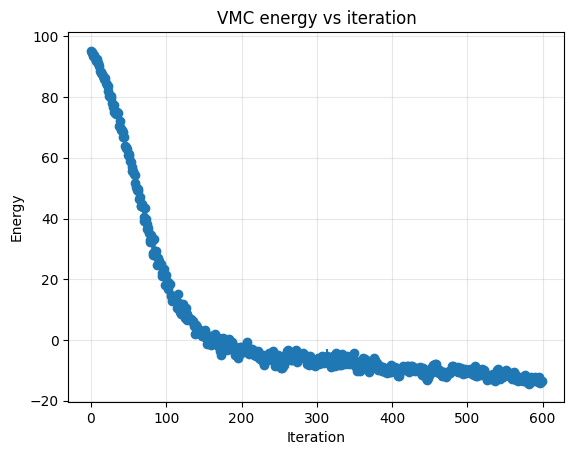

In [66]:
import matplotlib.pyplot as plt

iters      = E_hist.iters
energy     = E_hist.Mean.real
energy_err = E_hist.Sigma.real

plt.errorbar(
    iters,
    energy,
    yerr=energy_err,
    fmt="o-",
)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VMC energy vs iteration")
plt.grid(True, alpha=0.3)
plt.show()
